## Spam Classifier Palm Code Practical Challange

Given the email with spam event, I would create a classifier that provide probability spam output for the text input. The aim is to properly explore the dataset and get the best model.

### Data Exploration

In the first step, we would explore the given data and understand what happen.

In [2]:
# Import the necessary package
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Read the datasset
df = pd.read_csv('spam_emails.csv')

First, I want to see the overall data we have and have the initial feels of the data

In [4]:
#Examine the number of the words and the email character length
df['text_length'] = df['email'].apply(len)
df['email_words'] = df['email'].str.split().apply(len)

In [5]:
df

,email,spam,text_length,email_words
0,on thu may escapenumber escapenumber at escape...,0,143,18
1,vip replica we offer a free gift box with ever...,1,1080,187
2,on wed jun escapenumber escapenumber at escape...,0,1265,216
3,author metze date escapenumber escapenumber es...,0,9753,1338
4,hi i' trying to learn how to use lme for linea...,0,979,186
...,...,...,...,...
31371,dear list i have a dataset that provides sampl...,0,779,134
31372,"sure , let me send you the details :\n- up to ...",0,6456,1267
31373,thee this people riches of shamgar the royal c...,1,126,23
31374,hi\nwould you reflnance if you knew you ' d sa...,1,300,71


Looking at the data, I realize that the email might have been preprocessed but I am not sure the whole extend. I am only sure about the lowercasing, and I would assume that as the data sample that represent the population.

In [6]:
df['text_length'].median()

878.0

In [7]:
df['email_words'].median() 

153.0

In [8]:
# Examine the dataset label balance. We have a balanced dataset.
df['spam'].value_counts()

spam
1    16360
0    15016
Name: count, dtype: int64

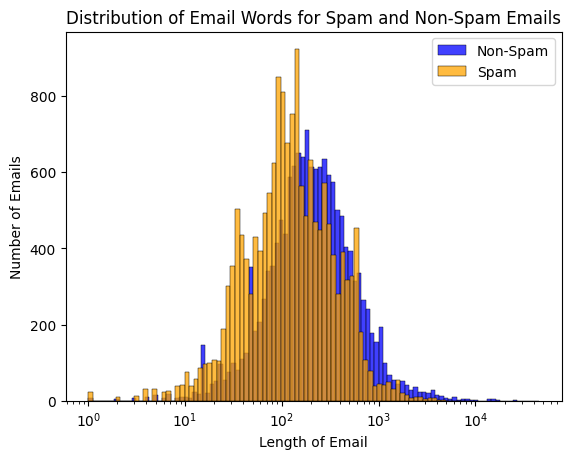

In [9]:
# Using Seaborn to see the differences between spam and non-spam for the number of words.
sns.histplot(df[df['spam'] ==0]['email_words'], color='blue', label='Non-Spam', kde=False, log_scale = True)
sns.histplot(df[df['spam'] ==1]['email_words'], color='orange', label='Spam', kde=False, log_scale = True)

plt.xlabel('Length of Email')
plt.ylabel('Number of Emails')
plt.title('Distribution of Email Words for Spam and Non-Spam Emails')
plt.legend()

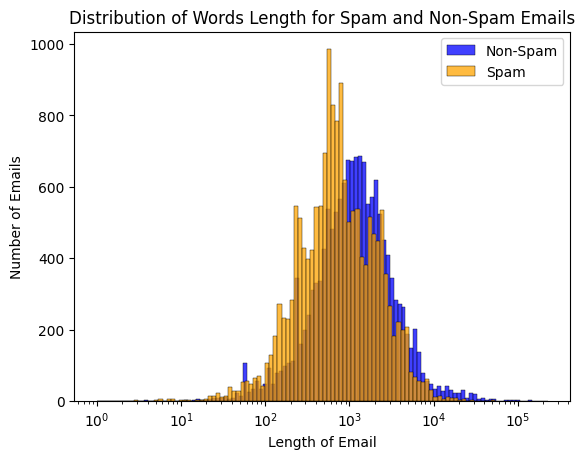

In [10]:
# Using Seaborn to see the differences between spam and non-spam for the words length.
sns.histplot(df[df['spam'] ==0]['text_length'], color='blue', label='Non-Spam', kde=False, log_scale = True)
sns.histplot(df[df['spam'] ==1]['text_length'], color='orange', label='Spam', kde=False, log_scale = True)

plt.xlabel('Length of Email')
plt.ylabel('Number of Emails')
plt.title('Distribution of Words Length for Spam and Non-Spam Emails')
plt.legend()

Coming from the visual information we generate above, the spam email is considerably shorter in the text length and the number of the words. 

For further word analysis, I would use wordcloud to visualize the words frequency that exist in our dataset.

In [11]:
from wordcloud import WordCloud

all_words_spam = ' '.join(list(df[df['spam'] == 0]['email']))
all_words_not_spam = ' '.join(list(df[df['spam'] == 1]['email']))
wordcloud_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_spam)
wordcloud_not_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_not_spam)

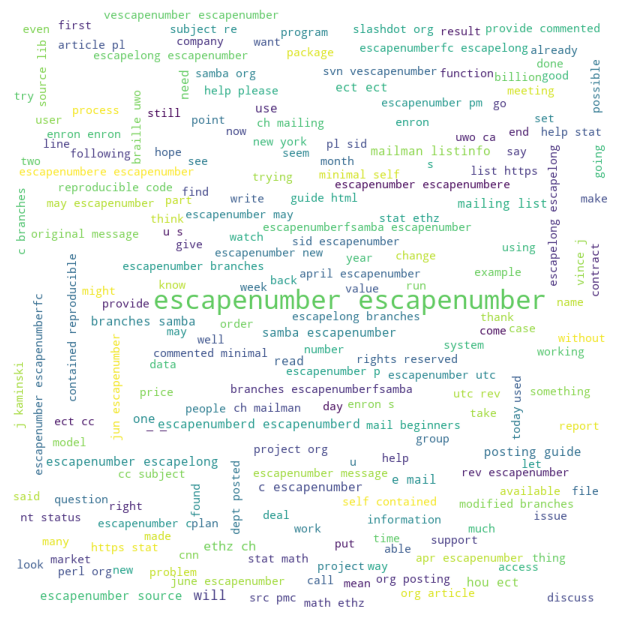

In [12]:
# Display the Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

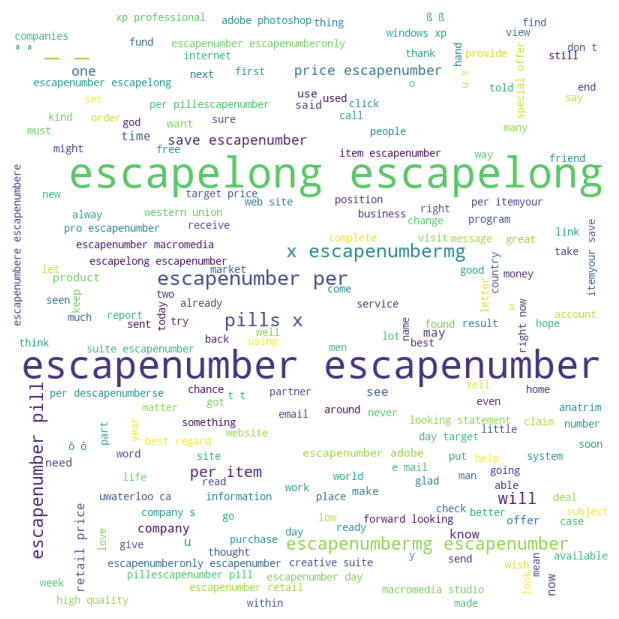

In [13]:
# Display the Not Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_not_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Comparing the email for the spam and not spam wordclouds, there are many words that contains the string "escape". I am assume them as a special character, so I would try to remove them to have a better view of the wordclouds. 

However, I would separate the original data with any preprocessing for further experiments. 

In [16]:
#Remove Special Character from the email, including the any word contains escape except the word escape itself

import re

def remove_sp(text):
    return re.sub(r'\b(?!escape\b)\w*escape\w*\b', '', re.sub(r'[^a-z\s]', '', text))

df['email_remove_sp'] = df['email'].apply(remove_sp)

#### Remove Special Character Wordcloud

In [15]:
all_words_remove_sp_spam = ' '.join(list(df[df['spam'] == 0]['email_remove_sp']))
all_words_remove_sp_not_spam = ' '.join(list(df[df['spam'] == 1]['email_remove_sp']))
wordcloud_remove_sp_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_remove_sp_spam)
wordcloud_remove_sp_not_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_remove_sp_not_spam)

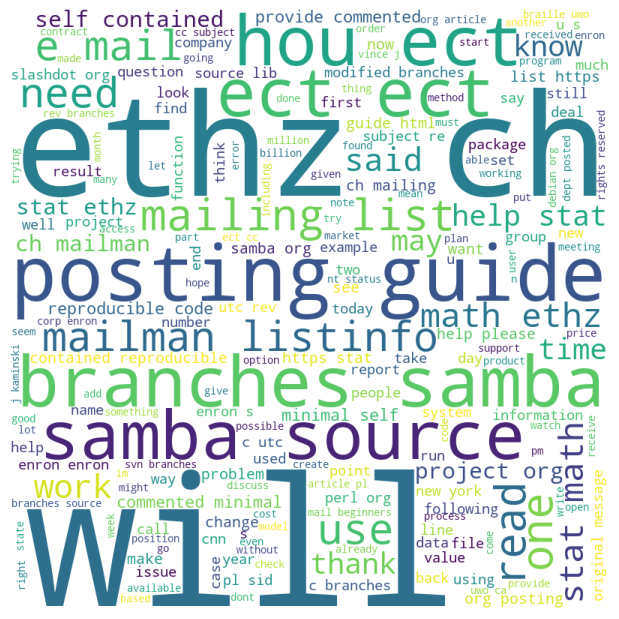

In [20]:
# Display the Removed Special Character Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_remove_sp_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

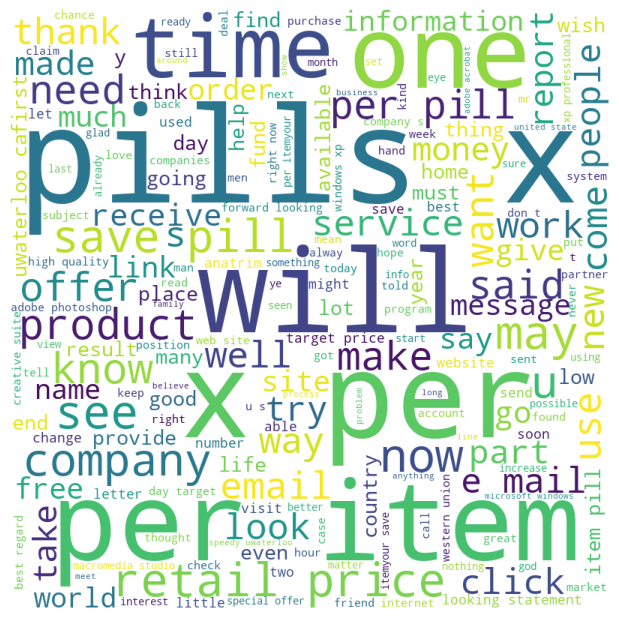

In [21]:
# Display the Removed Not Special Character Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_remove_sp_not_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

We can see a better difference between spam and not-spam words, where there are words that separate between the class. However, some stopwords such as will might distort the result. I would try to see how's the wordcloud without stopword.

#### Remove Special Character and Stopwords wordcloud

In [22]:
#Import and download some of the corpus that important for the next process
import nltk

# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('omw-1.4')


In [23]:
# Set the english stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

eng_stop_words = set(stopwords.words('english'))

In [24]:
# Remove stopwords from the email that have been processed before
def remove_stop(text):
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word not in eng_stop_words])
    return filtered_text
df['email_remove_sp_stop'] = df['email_remove_sp'].apply(remove_stop)

In [25]:
all_words_remove_sp_stop_spam = ' '.join(list(df[df['spam'] == 0]['email_remove_sp_stop']))
all_words_remove_sp_stop_not_spam = ' '.join(list(df[df['spam'] == 1]['email_remove_sp_stop']))
wordcloud_remove_sp_stop_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_remove_sp_stop_spam)
wordcloud_remove_sp_stop_not_spam = WordCloud(width = 800, height = 800, background_color ='white').generate(all_words_remove_sp_stop_not_spam)

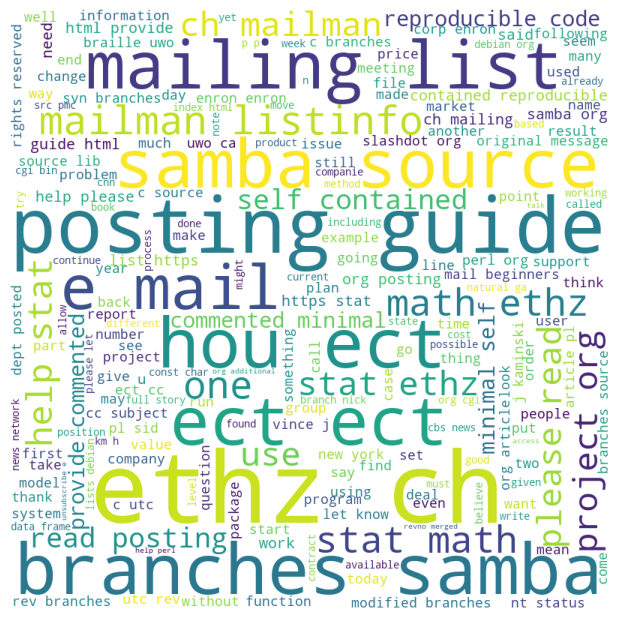

In [26]:
# Display the Removed Special Character and Stopwords Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_remove_sp_stop_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

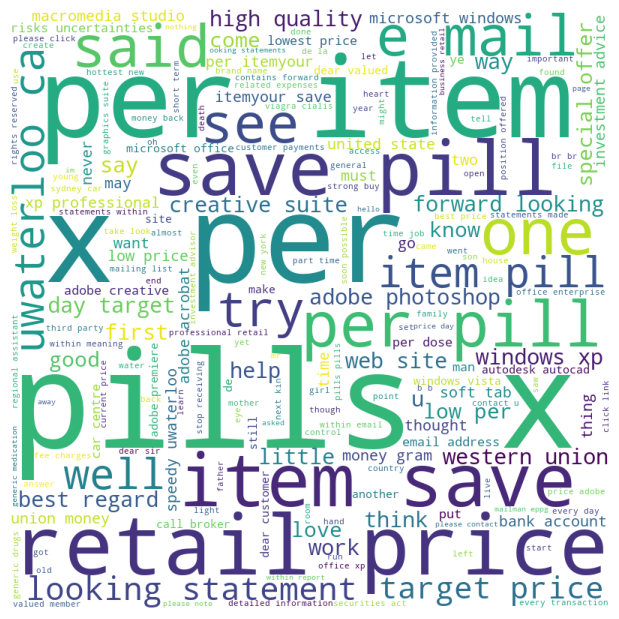

In [27]:
# Display the Removed Special Character and Stopwords Not Spam wordcloud image
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_remove_sp_stop_not_spam) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Overall, there are difference between the words used in the spam and not-spam email. The spam word focus in many words that focus in the mail itself such as posting, guide, please read. With some words that shown differences, it certainly possible to develop spam classifier based on the data.

## Spam Classifier Modelling Experiments

I want to test few models with different datasets and techniques to see the best methods to choose.

For the dataset, I want to experiment with 5 kinds of situations:
1. Original Data
2. Data with special character removed
3. Data with special character and stopwords removed
4. Data with special character and stopwords removed also stemmed
5. Data with special character and stopwords removed also lemmatized

To continue with the experiment, I would experiment the with the vectorization methods:
1. Bag of Words (BoW)
2. TF-IDF

We transform the text data into Bag of Words so the models can accept the data (as the model we would experiment only accept numerical data). We also want to use TF-IDF vectorization in order to give weight information to the words. For this experiment, I want to try the technique in their default parameter.

For the models experiment, I want to experiment with model that often used for text classification problem and offer a simple solution. Also, I would use their default parameter as well (no hyperparameter tuning). The model I would use are:
1. Naive Bayes
2. Logistic Regression
3. SVC
4. Random Forest
5. XGBoost

For the evaluation strategy, I would split the dataset into training data and test data. For the evaluation process, I would use Cross-Validation method to measure the perfomance stability. I would evaluate the model to the test data to see if the best model chosen is valid.

As for the metrics used, I would use the following:

1. Accuracy
2. Precision
3. Recall
4. F1 Score

However, I would use the precision metric to choose the model I would use. This is because Precision taking account False Positive information in their equation, and I would assume business wants to minimize False Positive in their spam prediction.
False Positive in our spam classifier means that the email predicted as spam is actually not-spam. We want to minimize that case as we don't want a real email classify as spam.

The model that I would choose would then the simplest model with minimal preprocessing process if possible, but still shown a great precision capability.

With that in mind, let's try out the experiment process.

In [28]:
# Stemming and Lemmatization processing.
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
    
    word_tokens = word_tokenize(text)
    stemmed_text = ' '.join([stemmer.stem(word) for word in word_tokens])
    return stemmed_text

def lemmatize_text(text):
    
    word_tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return lemmatized_text

I would separate the data that processed by steming and lemmatization.

In [29]:
df['email_remove_sp_stop_stem'] = df['email_remove_sp_stop'].apply(stem_text)

In [30]:
df['email_remove_sp_stop_lemm'] = df['email_remove_sp_stop'].apply(lemmatize_text)

In [17]:
#Splitting the dataset into training and test. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('spam', axis =1), df['spam'], test_size = 0.2, stratify = df['spam'], random_state = 42)

In [32]:
# initiate the experiment name

import mlflow

EXPERIMENT_NAME = "NLP-Spam-Classifier-Experiment"
# EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)


In [2]:
# !mlflow ui

^C


In [41]:
current_experiment=dict(mlflow.get_experiment_by_name(EXPERIMENT_NAME))
experiment_id=current_experiment['experiment_id']

In [20]:
import mlflow.data
from mlflow.data.pandas_dataset import PandasDataset
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [51]:
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def evaluate_models(train_data, train_labels, experiment_id):
    
    training_df = pd.concat([X_train['email'], y_train], axis =1).reset_index(drop = True)
    # Models to evaluate
    models = {
        "Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    # Metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1': make_scorer(f1_score)}

    # Vectorizations
    vectorizers = {
        "BoW": CountVectorizer(),
        "TF-IDF": TfidfVectorizer()
    }
    
    results = []
    for vect_name, vectorizer in vectorizers.items():
            X = vectorizer.fit_transform(train_data)

            for model_name, model in models.items():
                vect_mod_name = vect_name +'_'+model_name
                # Cross-Validate the model
                RUN_NAME = f"run_{vect_mod_name}"
                mlflow.end_run()
                with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
                    # Retrieve run id
                    RUN_ID = run.info.run_id

                    cv_results = cross_validate(model, X, train_labels, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=3, return_train_score=False)
                    for i in range(3):
                        iteration_result = {
                            'Iteration': i + 1,
                            'Model': model_name,
                            'Vectorizer': vect_name,
                            'Accuracy': cv_results['test_accuracy'][i],
                            'Precision': cv_results['test_precision'][i],
                            'Recall': cv_results['test_recall'][i],
                            'F1 Score': cv_results['test_f1'][i]
                        }
                        results.append(iteration_result)                       
                    # Calculating the metrics means
                    mean_result = {
                        'Iteration': 'Mean',
                        'Model': model_name,
                        'Vectorizer': vect_name,
                        'Accuracy': np.mean(cv_results['test_accuracy']),
                        'Precision': np.mean(cv_results['test_precision']),
                        'Recall': np.mean(cv_results['test_recall']),
                        'F1 Score': np.mean(cv_results['test_f1'])
                    }
                    results.append(mean_result)
                    
                    
                    # Track metrics
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_accuracy", mean_result['Accuracy'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_precision", mean_result['Precision'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_recall", mean_result['Recall'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_f1", mean_result['F1 Score'])
                    # Track model
                    model.fit(X, train_labels)
                    training_df["ModelOutput"] = model.predict(X)
                    dataset = mlflow.data.from_pandas(training_df, targets="spam", predictions="ModelOutput", name = f"data_{vect_mod_name}")
                    mlflow.log_input(dataset, context="training")
                    
                    if model_name == "XGBoost":
                        mlflow.xgboost.log_model(model, "model")
                    else:
                        mlflow.sklearn.log_model(model, "model")
                                
                    mlflow.end_run() 
        
 
    return pd.DataFrame(results)


I would start the experiment with the original data.

In [52]:
email_res = evaluate_models(X_train['email'], y_train, experiment_id)

In [3]:
mlflow.end_run()

To understand the result better, I would create a line plot visualization for each of the metrics.

In [53]:
def viz_result_metric(data):
    plt.figure(figsize=(15, 8))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.lineplot(data=data, x='Iteration', y=metric, hue='Model', style='Vectorizer', markers=True)
        plt.title(f'Model Performance: {metric}')
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.legend(title='Models / Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [60]:
email_res

,Iteration,Model,Vectorizer,Accuracy,Precision,Recall,F1 Score
0,Mean,Naive Bayes,BoW,0.972112,0.983456,0.962714,0.972973
1,3,Naive Bayes,BoW,0.973703,0.984558,0.964695,0.974525
2,Mean,Logistic Regression,BoW,0.979522,0.973849,0.987240,0.980496
3,3,Logistic Regression,BoW,0.980277,0.972742,0.989913,0.981252
4,Mean,Random Forest,BoW,0.973108,0.975271,0.973105,0.974184
5,3,Random Forest,BoW,0.973703,0.973480,0.976158,0.974817
6,Mean,XGBoost,BoW,0.976574,0.966769,0.989074,0.977794
7,3,XGBoost,BoW,0.978365,0.969248,0.989913,0.979471
8,Mean,Naive Bayes,TF-IDF,0.970319,0.980761,0.961950,0.971263
9,3,Naive Bayes,TF-IDF,0.970476,0.982189,0.960798,0.971376


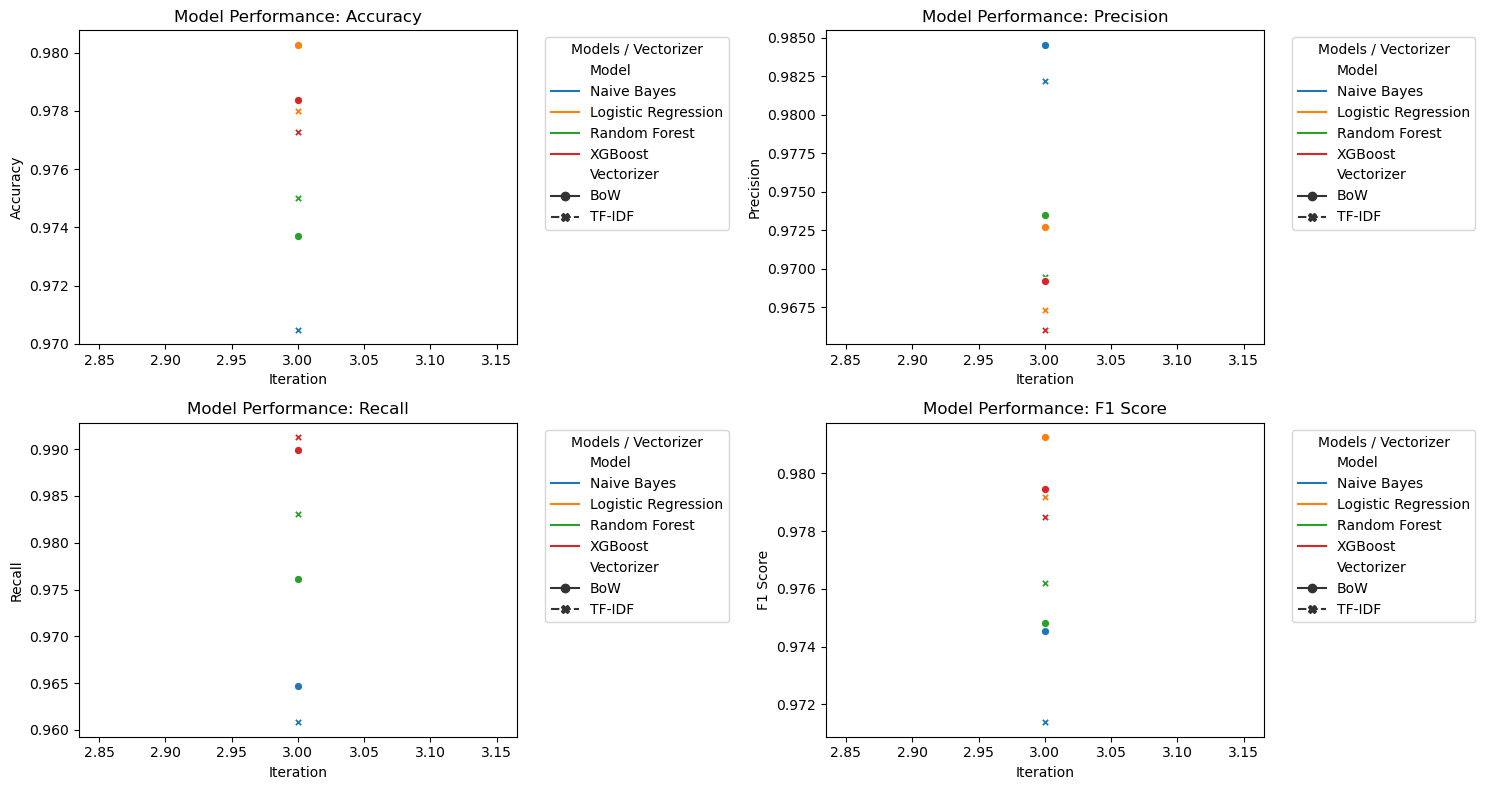

In [54]:
# Visualize the data iteration but exclude the metrics Mean
viz_result_metric( email_res[email_res['Iteration'] != 'Mean'])

I would also visualize the metrics mean for each of the metrics

In [55]:
def viz_result_metric_mean(data):
    mean_data = data[data['Iteration'] == 'Mean'].pivot(index='Vectorizer', columns='Model', values=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    plt.figure(figsize=(16, 10))

    metrics = mean_data.columns.levels[0]
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.heatmap(mean_data[metric], annot=True, fmt=".3f", linewidths=.5, cmap='coolwarm')
        plt.title(metric)
        plt.ylabel('Vectorizer')
        plt.xlabel('Model')

    plt.tight_layout()
    plt.show()

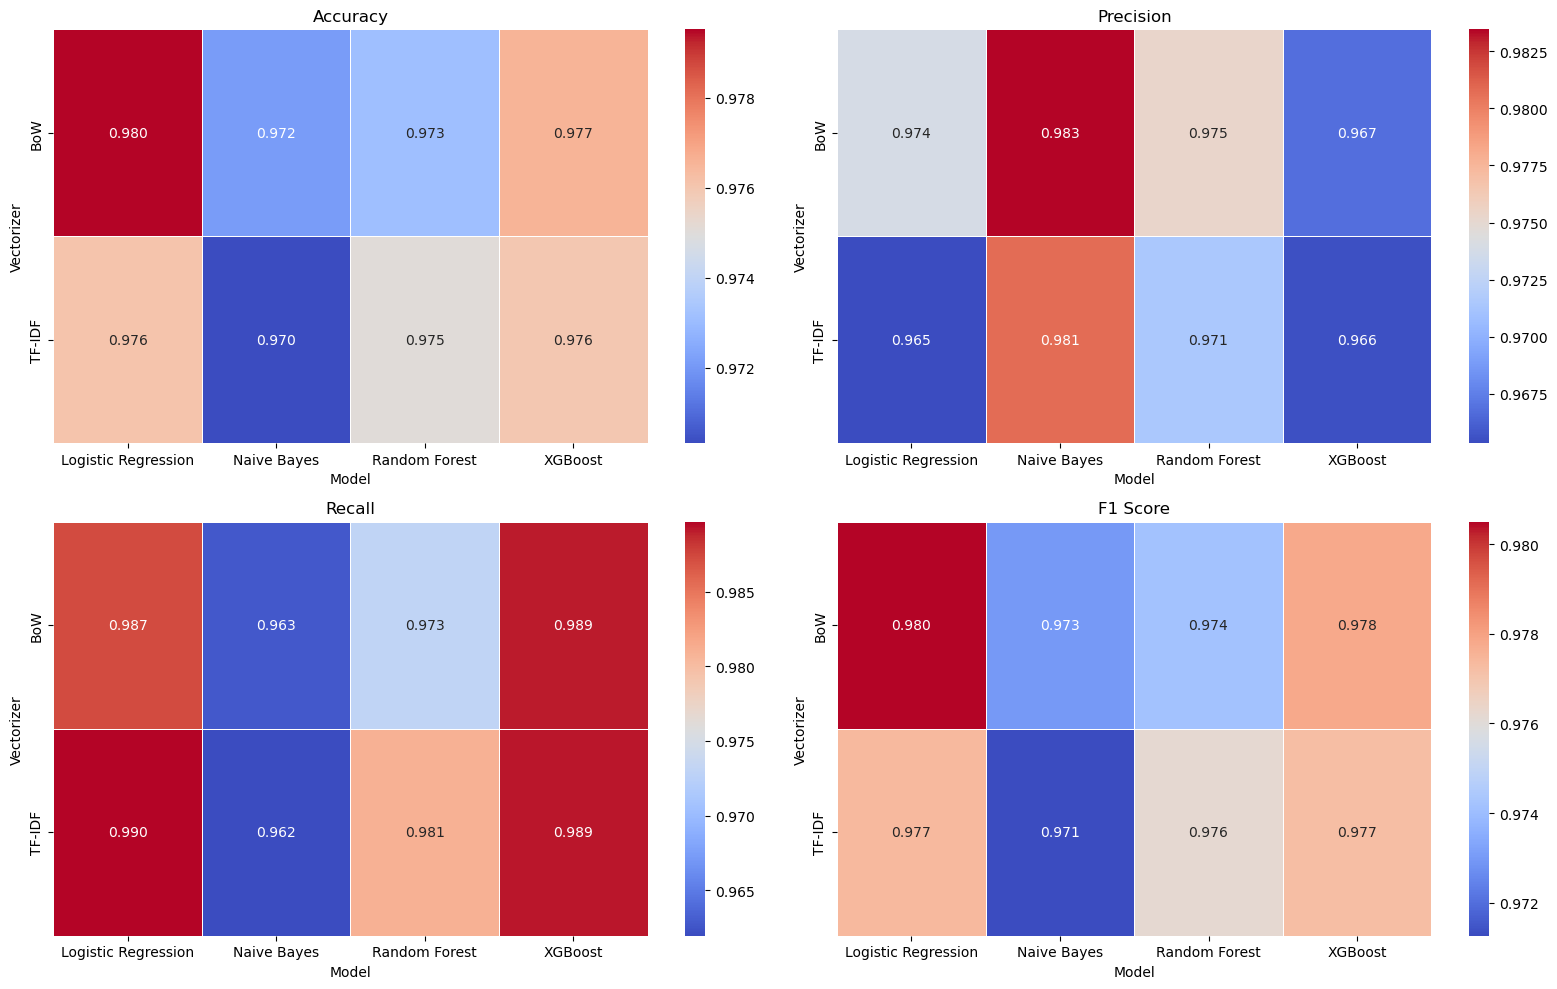

In [59]:
viz_result_metric_mean(email_res)

There are few important insight from our experiment with the original data, which are:

1. SVM might shown the worst performance with BoW vectorizer, but see a strong performance in the Accuracy and Recall metrics with the TF-IDF vectorizer.
2. Recall metrics shown more diverse result compared to the other metric, albeit not much.
3. Naive Bayes with BoW Vectorizer shown the best overall Precision metrics

In [57]:
email_res

,Iteration,Model,Vectorizer,Accuracy,Precision,Recall,F1 Score
0,Mean,Naive Bayes,BoW,0.972112,0.983456,0.962714,0.972973
1,3,Naive Bayes,BoW,0.973703,0.984558,0.964695,0.974525
2,Mean,Logistic Regression,BoW,0.979522,0.973849,0.987240,0.980496
3,3,Logistic Regression,BoW,0.980277,0.972742,0.989913,0.981252
4,Mean,Random Forest,BoW,0.973108,0.975271,0.973105,0.974184
5,3,Random Forest,BoW,0.973703,0.973480,0.976158,0.974817
6,Mean,XGBoost,BoW,0.976574,0.966769,0.989074,0.977794
7,3,XGBoost,BoW,0.978365,0.969248,0.989913,0.979471
8,Mean,Naive Bayes,TF-IDF,0.970319,0.980761,0.961950,0.971263
9,3,Naive Bayes,TF-IDF,0.970476,0.982189,0.960798,0.971376


The original data have already shown a great performance, which we would try in the test dataset. In this case, we would use the Naive Bayes in their default form.

#### Original Dataset Model Training

In [21]:
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()
naive_bayes_classifier = MultinomialNB()

# Creating a pipeline for the whole process
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', naive_bayes_classifier)
])

pipeline.fit(X_train['email'], y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [22]:
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test['email'])
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3004
           1       0.98      0.95      0.97      3272

    accuracy                           0.97      6276
   macro avg       0.97      0.97      0.97      6276
weighted avg       0.97      0.97      0.97      6276



Even in their default form, the Naive Bayes shown a strong performance capability. Let's try how the performance with the special character and removing certain words.

In [ ]:
email_res_sp = evaluate_models(X_train['email_remove_sp'], y_train)

In [ ]:
viz_result_metric( email_res_sp[email_res_sp['Iteration'] != 'Mean'])

In [ ]:
viz_result_metric_mean(email_res_sp)

There are no significant differences between model that trained in the original dataset and the removed character one. Let's test the model with the test data.

#### Removed Special Character Model Training

In [ ]:
pipeline.fit(X_train['email_remove_sp'], y_train)

In [ ]:
y_pred = pipeline.predict(X_test['email_remove_sp'])
report = classification_report(y_test, y_pred)
print(report)

The result shown not much significant change in the performance, rather the above result is slightly worse than the previous experiment. 

For the simplicity and based on the performance, I would train the model based on the original data and use that as basis for this model challange.

I would still provide the code for further experiment, but I would not process with that for now as the current result already shown a great performance.

In [ ]:
# email_res_sp_stop = evaluate_models(X_train['email_remove_sp_stop'], y_train)

In [ ]:
# email_res_sp_stop_stem = evaluate_models(X_train['email_remove_sp_stop_stem'], y_train)


In [ ]:
# email_res_sp_stop_lemm = evaluate_models(X_train['email_remove_sp_stop_lemm'], y_train)

## Model Generation

For now, I would Pickle our model pipeline if it's required. For that, I would use all the available dataset to train our model.

In [23]:
pipeline.fit(df['email'], df['spam'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [24]:
import pickle

with open('spam_classifier_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [25]:
import pickle
filename = 'spam_classifier_pipeline.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

In [16]:
import pandas as pd
prediction = model.predict(pd.Series('This is email'))[0]

In [11]:
import numpy as np
class_names = np.array(['Ham','Spam'])

In [14]:
class_names[prediction]

array(['Spam'], dtype='<U4')

In [13]:
class_names

array(['Ham', 'Spam'], dtype='<U4')